# Data Exploration

This notebook is intended for exploring movie preferences, ratings, and trends among movie reviewers.

I conducted a survey with people in my network to gather information about their movie preferences. The survey was designed using Google Forms and I was able to capture 36 responses, with each survey respondent rating between 5 and 10 movies. The survey questions were designed to capture general preferences and trends among movie lovers.

I also used data provided by MovieLens, obtained on Kaggle. More information on this dataset from Kaggle found at the bottom of this markdown cell.

I merged the survey responses with the MovieLens dataset to create a more complete dataset. The merged dataset can be found in the file "Movie_Ratings_Merged.csv". 

From the Kaggle dataset's description:

"Context
These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website."


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity




# Load the dataset
df = pd.read_csv('/Users/griffinulsh/Desktop/GitHub/Clemson_MSCS/CPSC8740/Personalized_Movie_Rec_System/Movie_Ratings_Merged.csv')

# Clean and prepare data
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')

# Inspect the dataset
print(df.head())

   userId                 title  rating                   genres_parsed  \
0       1       Dangerous Minds     2.5              ['Drama', 'Crime']   
1       1                 Dumbo     3.0         ['Animation', 'Family']   
2       1              Sleepers     3.0  ['Crime', 'Drama', 'Thriller']   
3       1  Escape from New York     2.0   ['Science Fiction', 'Action']   
4       1       Cinema Paradiso     4.0            ['Drama', 'Romance']   

                                     keywords_parsed     source release_date  \
0  ['rap music', 'karate', 'high school', 'naval ...  movielens   1995-08-11   
1  ['circus', 'mother', 'dream', 'mouse', 'elepha...  movielens   1941-10-22   
2  ['child abuse', 'sadistic', 'sexual abuse', 'p...  movielens   1996-10-18   
3  ['taxi', 'street gang', 'usa president', 'war ...  movielens   1981-05-22   
4  ['sicily', 'cinema', 'film director', 'kiss', ...  movielens   1988-11-17   

   runtime  release_year  
0     99.0        1995.0  
1     64.0    

In [3]:
# Count the number of ratings for each movie
most_rated_movies = df['title'].value_counts().reset_index()
most_rated_movies.columns = ['title', 'number_of_ratings']
print(most_rated_movies.head(10))  # Display the top 10 most rated movies

                        title  number_of_ratings
0                Forrest Gump                342
1                Pulp Fiction                325
2    The Shawshank Redemption                312
3    The Silence of the Lambs                304
4                   Star Wars                292
5               Jurassic Park                274
6                  The Matrix                259
7                   Toy Story                247
8            Schindler's List                244
9  Terminator 2: Judgment Day                237


In [10]:
# Calculate the average number of movies rated per user
average_movies_rated = df.groupby('userId')['title'].count().mean()
print(f"Average number of movies rated per reviewer: {average_movies_rated:.2f}")

Average number of movies rated per reviewer: 143.31


In [11]:
# Calculate basic statistics of ratings
rating_stats = df['rating'].describe()
print(rating_stats)

count    100227.000000
mean          3.543850
std           1.058228
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [12]:
# Count the number of ratings per user
most_active_users = df['userId'].value_counts().reset_index()
most_active_users.columns = ['userId', 'number_of_ratings']
print(most_active_users.head(10))  # Display the top 10 most active users

   userId  number_of_ratings
0     547               2399
1     564               1871
2     624               1741
3      15               1708
4      73               1612
5     452               1343
6     468               1291
7     380               1066
8     311               1022
9      30               1011


In [13]:
# Calculate the correlation between runtime and ratings
correlation = df['runtime'].corr(df['rating'])
print(f"Correlation between runtime and ratings: {correlation:.2f}")

Correlation between runtime and ratings: 0.12


In [14]:
# Convert release_date to datetime if not already done
df['release_date'] = pd.to_datetime(df['release_date'])

# Analyze ratings over time
ratings_over_time = df.groupby(df['release_date'].dt.year)['rating'].mean()
print(ratings_over_time)

release_date
1902.0    4.333333
1915.0    3.000000
1917.0    4.250000
1918.0    4.250000
1919.0    3.000000
            ...   
2012.0    3.403382
2013.0    3.343995
2014.0    3.443228
2015.0    3.372881
2016.0    3.301418
Name: rating, Length: 102, dtype: float64


# Ratings Distribution

Most ratings fall between 3 and 5 with a peak around 4.0. Very few ratings are below 2.0.

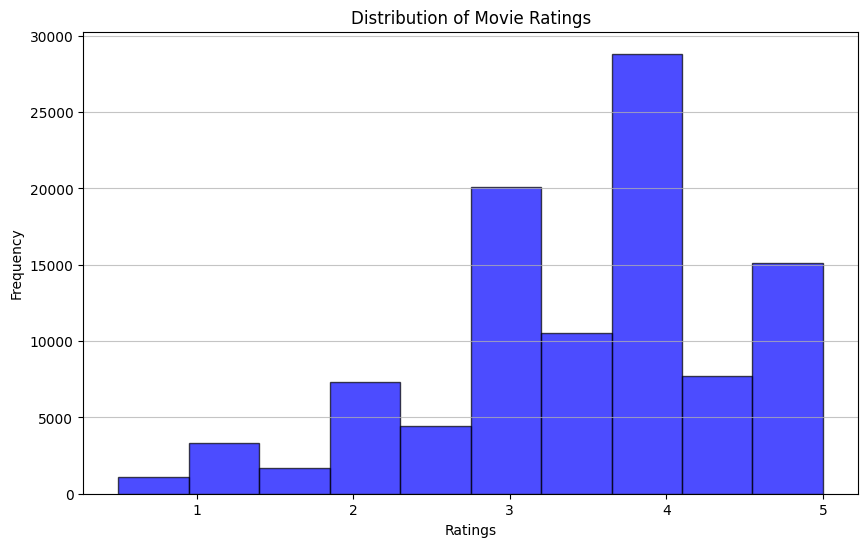

In [4]:
# Assuming you have a DataFrame 'df' with a column 'rating'
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Highest Rated Movies

This is just a quick look at what users rated the highest on average.

/var/folders/w2/5w3shfnd5v99snv7z_rbkrq00000gn/T/ipykernel_67191/1938528103.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_movies, x='mean', y='title', palette='Blues_d')


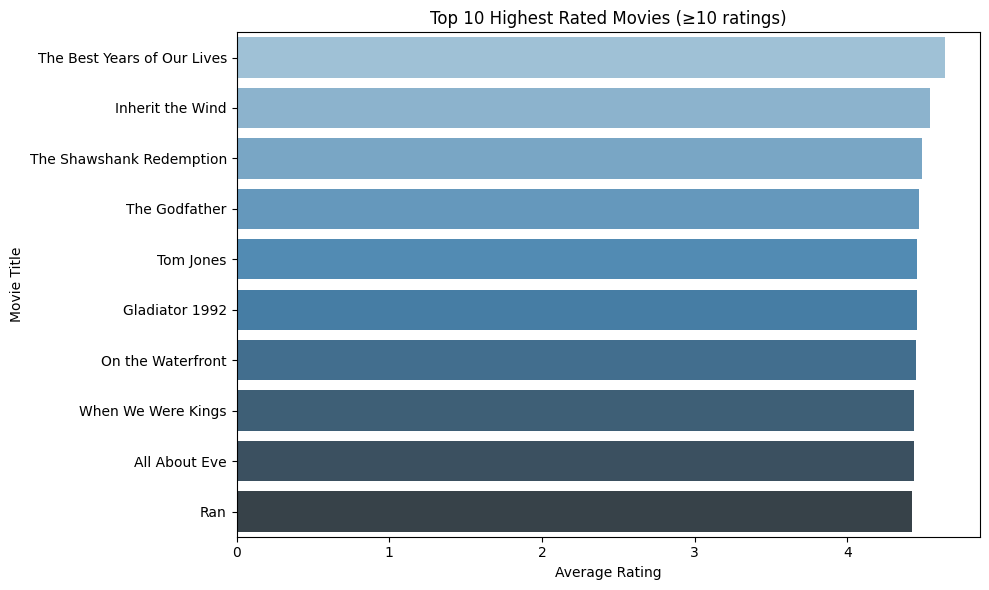

In [5]:
# Group by movie title and calculate average rating and number of ratings
top_movies = df.groupby('title')['rating'].agg(['count', 'mean']).reset_index()
top_movies = top_movies[top_movies['count'] >= 10].sort_values(by='mean', ascending=False).head(10)

# Plot top 10 highest-rated movies (with at least 10 ratings)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_movies, x='mean', y='title', palette='Blues_d')
plt.title("Top 10 Highest Rated Movies (≥10 ratings)")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()


In [6]:
# Create a user-item matrix
user_item_matrix = df.pivot_table(index='userId', columns='title', values='rating')

# Fill NaN values with 0 for similarity calculation
user_item_matrix_filled = user_item_matrix.fillna(0)

# Calculate cosine similarity
similarity_matrix = cosine_similarity(user_item_matrix_filled.T)  # Transpose to get movies as rows
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.columns, columns=user_item_matrix.columns)


In [9]:
def get_recommendations(movie_title, similarity_df, n_recommendations=5):
    if movie_title not in similarity_df:
        return f"Movie '{movie_title}' not found in the dataset."
    
    # Get the similarity scores for the specified movie
    similar_scores = similarity_df[movie_title]
    
    # Sort the movies based on similarity scores
    similar_movies = similar_scores.sort_values(ascending=False)
    
    # Get the top n recommendations (excluding the movie itself)
    recommendations = similar_movies[1:n_recommendations + 1]
    
    return recommendations

# Example usage
recommendations = get_recommendations("Free Willy", similarity_df)
print(recommendations)

title
Something to Talk About    0.457330
Fools Rush In              0.437690
Sleepless in Seattle       0.424716
Love Affair                0.415848
Forget Paris               0.408871
Name: Free Willy, dtype: float64


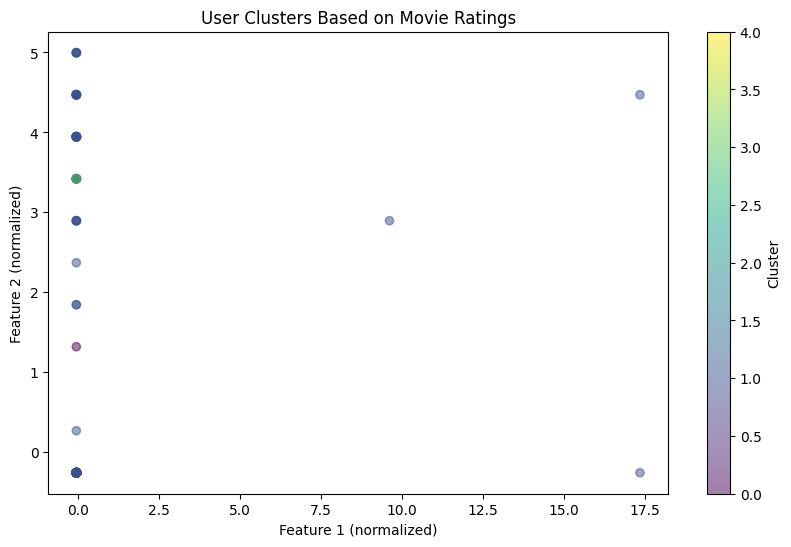

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Prepare user-item matrix
user_item_matrix = df.pivot_table(index='userId', columns='title', values='rating').fillna(0)

# Normalize the data
scaler = StandardScaler()
user_item_matrix_scaled = scaler.fit_transform(user_item_matrix)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # You can adjust the number of clusters
user_clusters = kmeans.fit_predict(user_item_matrix_scaled)

# Add cluster labels to the original user-item matrix
user_item_matrix['Cluster'] = user_clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(user_item_matrix_scaled[:, 0], user_item_matrix_scaled[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.title('User Clusters Based on Movie Ratings')
plt.xlabel('Feature 1 (normalized)')
plt.ylabel('Feature 2 (normalized)')
plt.colorbar(label='Cluster')
plt.show()

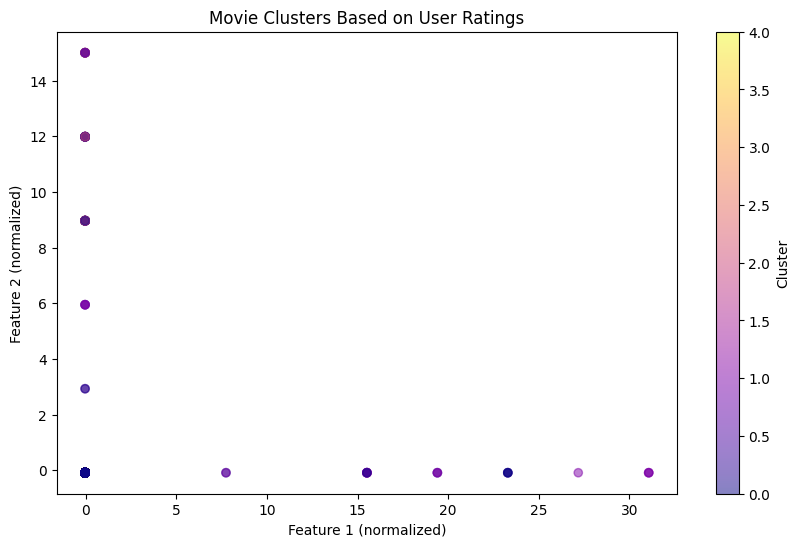

In [7]:
# Prepare movie-user matrix
movie_user_matrix = df.pivot_table(index='title', columns='userId', values='rating').fillna(0)

# Normalize the data
movie_user_matrix_scaled = scaler.fit_transform(movie_user_matrix)

# Apply K-Means clustering
movie_clusters = kmeans.fit_predict(movie_user_matrix_scaled)

# Add cluster labels to the original movie-user matrix
movie_user_matrix['Cluster'] = movie_clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(movie_user_matrix_scaled[:, 0], movie_user_matrix_scaled[:, 1], c=movie_clusters, cmap='plasma', alpha=0.5)
plt.title('Movie Clusters Based on User Ratings')
plt.xlabel('Feature 1 (normalized)')
plt.ylabel('Feature 2 (normalized)')
plt.colorbar(label='Cluster')
plt.show()

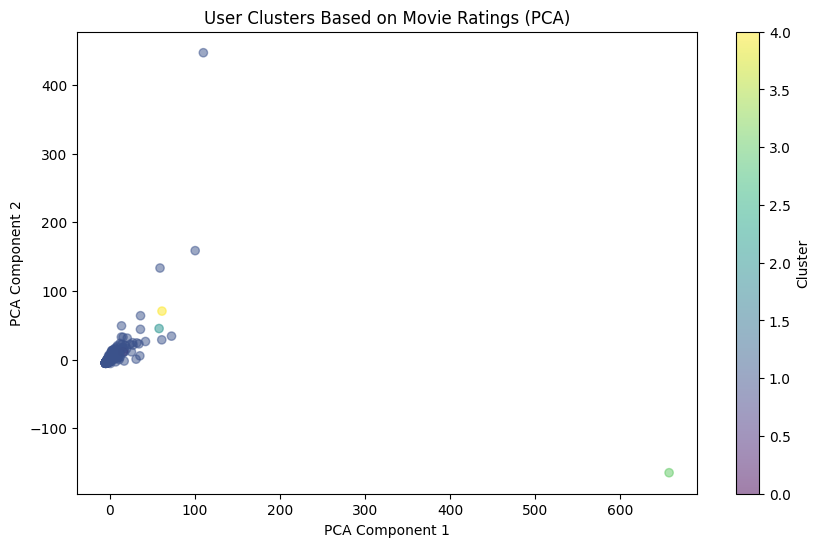

In [8]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
user_item_matrix_pca = pca.fit_transform(user_item_matrix_scaled)

# Visualize the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(user_item_matrix_pca[:, 0], user_item_matrix_pca[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.title('User Clusters Based on Movie Ratings (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()